```{index} single: Pyomo; block
```
```{index} single: Pyomo; sets
```
```{index} single: Pyomo; parameters
```
```{index} single: solver; cbc
```
```{index} single: application; production planning
```
```{index} pandas dataframe
```

# 3.6 BIM production revisited

## Preamble: Install Pyomo and a solver

The following cell sets and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and the HiGHS solver, while, if run elsewhere, it 
assumes Pyomo and HiGHS have been previously installed. It then sets to use HiGHS as solver via the appsi module and a test is performed to verify that it is available. The solver interface is stored in a global object `SOLVER` for later use.

In [1]:
import sys
 
if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
 
solver = 'appsi_highs'
 
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)
 
assert SOLVER.available(), f"Solver {solver} is not available."

## Problem description

We consider again the [BIM raw material planning problem](../02/01-bim-rawmaterialplanning.ipynb) from Chapter 2 but with more sophisticated pricing and acquisition protocols. There are now three suppliers, each of which can deliver the following materials:
 - A: **silicon**, **germanium** and **plastic**
 - B: **copper**
 - C: all the above
 
For the suppliers, the following conditions apply: copper should be acquired in multiples of 100 gram, since it is delivered in sheets of that weight. Unitary materials such as silicon, germanium and plastic may be acquired in any number, but the price is in batches of 100. Meaning that 30 units of silicon with 10 units of germanium and 50 units of plastic cost as much as 1 unit of silicon but half as much as 30 units of silicon with 30 units of germanium and 50 units of plastic. Furthermore, supplier C sells all materials and offers a discount if purchased together: 100 gram of copper and a batch of unitary material cost only 7. This set price is only applied to pairs, meaning that 100 gram of copper and 2 batches cost 13.

The summary of the prices in $ is given in the following table:

<div align="center">

|Supplier|Copper per sheet of 100 gram|     Batches|Together|
|:-------|---------------------:|-----------------:|-------:|
| A      |                    - |                5 |      - |
| B      |                    3 |                - |      - |
| C      |                    4 |                6 |      7 |

</div>

Next, for stocked products inventory costs are incurred, whose summary is given in the following table:

<div align="center">

|Copper per 10 gram| Silicon per unit| Germanium per unit|Plastic per unit|
|---:|-------:|---:|-----:|
| 0.1|   0.02 |0.02| 0.02 |

</div>

The holding price of copper is per 10 gram and the copper stocked is rounded up to multiples of 10 grams, meaning that 12 grams pay for 20. The capacity limitations of the warehouse allow for a maximum of $10$ kilograms of copper in stock at any moment, but there are no practical limitations to the number of units of unitary products in stock. The production is made-to-order, meaning that no inventory of chips is kept.

Recall that BIM has the following stock at the beginning of the year:

<div align="center">

|Copper |Silicon |Germanium |Plastic|
|---:|-------:|---:|-----:|
| 480|   1000 |1500| 1750 |

</div>

The company would like to have at least the following stock at the end of the year:

<div align="center">

|Copper |Silicon |Germanium |Plastic|
|---:|-------:|---:|-----:|
| 200|    500 | 500| 1000 |

</div>

The goal is to build an optimization model using the data above and solve it to minimize the acquisition and holding costs of the products while meeting the required quantities for production. 


## Data import

In the next cell we import and store the data described in dictionaries or Pandas dataframes.

In [2]:
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo

demand_data = """
chip, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
logic, 88, 125, 260, 217, 238, 286, 248, 238, 265, 293, 259, 244
memory, 47, 62, 81, 65, 95, 118, 86, 89, 82, 82, 84, 66
"""

demand_chips = pd.read_csv(StringIO(demand_data), index_col="chip")
display(demand_chips)

use = dict()
use["logic"] = {"silicon": 1, "plastic": 1, "copper": 4}
use["memory"] = {"germanium": 1, "plastic": 1, "copper": 2}
use = pd.DataFrame.from_dict(use).fillna(0).astype(int)
display(use)

demand = use.dot(demand_chips)
display(demand)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
logic,88,125,260,217,238,286,248,238,265,293,259,244
memory,47,62,81,65,95,118,86,89,82,82,84,66


,logic,memory
silicon,1,0
plastic,1,1
copper,4,2
germanium,0,1


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,88,125,260,217,238,286,248,238,265,293,259,244
plastic,135,187,341,282,333,404,334,327,347,375,343,310
copper,446,624,1202,998,1142,1380,1164,1130,1224,1336,1204,1108
germanium,47,62,81,65,95,118,86,89,82,82,84,66


## Optimization model

As usual, we need to start modeling by naming our decisions and identifying the relevant index sets. In the [previous BIM notebook](../02/bim-rawmaterialplanning.ipynb) we already had a set $T$ time periods (i.e., the months) and a set $P$ for the products. Since we want to keep track of how much we buy for which material and from which supplier, we need an additional index set $S$ for the suppliers.

In the [previous BIM notebook](../02/bim-rawmaterialplanning.ipynb) all decision variables were continuous, but now we also need to take care of a number of integer decision variables:

- number of batches of the unitary products;
- number of copper sheets;
- number of volume units in stock, since the inventory of copper pays per $10$ g;
- number of copper sheet-batch of unitary product pairs acquired in the same month from supplier C, yielding discount.

Given the above, we can clearly reuse the variables $s_{pt}$ from [previous BIM notebook](../02/bim-rawmaterialplanning.ipynb) to account for the total number of grams/units of each product. With respect to purchasing variables, however, we now need to keep track of unitary products and suppliers. For this reason, we introduce the integer variables $y_{ts}$ for the number of copper sheets purchased from supplier $s$, and continuous variables $x_{pts}$ for the number of units of unitary product $p$ purchased from supplier $s$. To translate these variables into `amounts of a product purchased regardless of the supplier', we introduce another variable $u_{pt}$.

Further, we introduce the variables that we use to account for the tricky integer quantities in our model. To account for the number of batches of unitary products at supplier $s$, we introduce integer variables $b_{ts}$, and, similarly, we introduce an integer variable $r_t$ for the number of 10 g copper batches in the inventory. Buying a copper sheet together with a batch of unitary products from supplier C is advantageous as we get a discount of $\beta = 4 + 6 - 7$. For this reason, we introduce an extra integer variable $p_t$ to count the number of such pairs, so that $\beta p_t$ describes the amount to the total discount acquired in month $t$. We need to include additional constraints to make sure that these three variables `take the values they should' in relation to the purchasing and inventory variables.

Taking all the above into account, we shall use the following decision variables:

- $y_{ts}$: number of sheets of copper purchased in month $t$ from supplier $s$
- $x_{pts}$: number of units of unitary product $p$ purchased in month $t$ from supplier $s$
- $u_{pt}$: total number of units of product $p$ purchased in month $t$ (from all suppliers combined)
- $b_{ts}$: number of batches of 100 unitary products purchased in month $t$ from supplier $s$
- $p_{t}$: number of batch-copper sheet pairs purchased in month $t$ from supplier C 
- $r_t$: number of 10-unit amounts of copper (rounded up) in month $t$.

We begin by formulating the objective function using \$ cents as unit. If we denote by $\alpha_s$ the per-batch cost of unitary products at supplier $s$, then the total material acquisition cost is

$$
\begin{equation*}
    \sum_{t \in T} \Big( \sum_{s \in S} \pi_{s} b_{ts} + \alpha_{s} y_{ts} \Big) - \beta p_t \Big),
\end{equation*}
$$

where we count the acquisition costs for supplier $C$ as the total cost of the sheets of copper plus the batches of unitary materials minus the discount due to purchasing the pairs:

$$
\begin{equation*}
    \pi_{\text{C}} b_{t, \text{C}} + \alpha_{\text{C}} y_{t, \text{C}}  - \beta p_t.
\end{equation*}
$$

The total inventory cost is

$$
\begin{equation*}
    \sum_{t \in T} \Big(  0.1 r_t + \sum_{p \in P \setminus\{\text{copper}\}} h_p s_{pt}  \Big).
\end{equation*}
$$

Now, we need to construct a system of constraints to ensure that the above costs are computed correctly. To transform the amounts of unitary materials purchased into batches of $100$, we construct the following constraints:

$$
\begin{equation*}
    \sum_{p \in P \setminus\{\text{copper}\}}  x_{pts} \leq 100 b_{ts}.
\end{equation*}
$$

Because the inventory costs for copper are computed by rounding up to 10 g amounts, we account for this via the following constraint

$$
\begin{equation*}
    s_{\text{copper}, t} \leq 10 r_t.
\end{equation*}
$$

In the end, we can account for the number of sheets of copper-unitary material batch pairs purchased at supplier C, we can use the following constraints:

$$
\begin{equation*}
    p_t \leq b_{t,\text{C}}, \quad \text{ and } \quad p_t \leq y_{t, \text{C}}.
\end{equation*}
$$

Choosing the maximum possible amount $p_t$ that satisfies such constraints will naturally lead to maximizing the number of pairs and, thus, the total discount.

The remaining constraints such as the inventory balance constraints, total inventory capacity etc.~are straightforward, which gives us the following complete model formulation:

$$
\begin{align*}
    \min \quad & \sum_{t \in T} \Big( \Big( \sum_{s \in S} \pi_{s} b_{ts} + \alpha_{s} y_{ts} \Big) - \beta p_t \Big) +&
    \sum_{t \in T} \Big (  \gamma_{\text{copper}} r_t + \sum_{p \in P \setminus \{ \text{copper}\}} \gamma_{p} s_{pt}  \Big) \\
    \textup{s.t.} \quad 
    & \sum_{p \in P \setminus \{ \text{copper}\}} x_{pts} \leq 100 \cdot b_{ts} & \forall \, t \in T, \, \forall \, s \in S\\
    & s_{\text{copper}, t} \leq 10 \cdot r_t & \forall \, t \in T\\
    & s_{\text{copper}, t} \leq 10000 & \forall \, t \in T\\
    & u_{\text{copper}, t} = 100 \sum_{s \in S} y_{ts} & \forall \, t \in T\\
    & p_t \leq b_{t,\text{C}}, \quad p_t \leq y_{t, \text{C}} & \forall \, t \in T \\
    & u_{pt} = \sum_{s \in S} x_{pts} & \forall \, t \in T, \, \forall P \setminus \{ \text{copper}\}\\
    & s_{p,t-1} + u_{p,t} = \delta_{pt} + s_{pt} & \forall \, t \in T, \, \forall p \in P\\ 
    & s_{p \textrm{Dec}} \geq \Omega_p &  \forall \, p \in P \\
    & b_{ts}, r_t \in \mathbb{Z}_{+} & \forall \, t \in T, \, \forall \, s \in S,
\end{align*}
$$

where we assume that $s_{p,t-1}$ represents the initial inventory state. Note that because $r_t$, $b_{ts}$ appear with a non-negative coefficient and $p_t$ with a positive coefficient in the objective functions, at the optimal solution these variables will automatically take their minimal ($r_t$, $b_{ts}$) and maximal ($p_t$) values allowed by the corresponding constraints.

## Pyomo implementation

In the next cell, we implement the model described above in Pyomo using a function that can take the data as input arguments, so we can then easily use it with different data.

In [3]:
def BIMproduction_v1(
    demand,
    existing,
    desired,
    stock_limit,
    supplying_copper,
    supplying_batches,
    price_copper_sheet,
    price_batch,
    discounted_price,
    batch_size,
    copper_sheet_mass,
    copper_bucket_size,
    unitary_products,
    unitary_holding_costs,
):
    m = pyo.ConcreteModel(
        "BIM product acquisition and inventory with sophisticated prices"
    )

    periods = demand.columns
    products = demand.index
    first = periods[0]
    prev = {j: i for i, j in zip(periods, periods[1:])}
    last = periods[-1]

    @m.Param(products, periods)
    def delta(m, p, t):
        return demand.loc[p, t]

    @m.Param(supplying_batches)
    def pi(m, s):
        return price_batch[s]

    @m.Param(supplying_copper)
    def kappa(m, s):
        return price_copper_sheet[s]

    @m.Param()
    def beta(m):
        return price_batch["C"] + price_copper_sheet["C"] - discounted_price

    @m.Param(products)
    def gamma(m, p):
        return unitary_holding_costs[p]

    @m.Param(products)
    def Alpha(m, p):
        return existing[p]

    @m.Param(products)
    def Omega(m, p):
        return desired[p]

    m.y = pyo.Var(periods, supplying_copper, domain=pyo.NonNegativeIntegers)
    m.x = pyo.Var(
        unitary_products, periods, supplying_batches, domain=pyo.NonNegativeReals
    )
    m.s = pyo.Var(products, periods, domain=pyo.NonNegativeReals)
    m.u = pyo.Var(products, periods, domain=pyo.NonNegativeReals)
    m.b = pyo.Var(periods, supplying_batches, domain=pyo.NonNegativeIntegers)
    m.p = pyo.Var(periods, domain=pyo.NonNegativeIntegers)
    m.r = pyo.Var(periods, domain=pyo.NonNegativeIntegers)

    @m.Constraint(periods, supplying_batches)
    def units_in_batches(m, t, s):
        return (
            pyo.quicksum(m.x[p, t, s] for p in unitary_products)
            <= batch_size * m.b[t, s]
        )

    @m.Constraint(periods)
    def copper_in_buckets(m, t):
        return m.s["copper", t] <= copper_bucket_size * m.r[t]

    @m.Constraint(periods)
    def inventory_capacity(m, t):
        return m.s["copper", t] <= stock_limit

    @m.Constraint(periods)
    def pairs_in_batches(m, t):
        return m.p[t] <= m.b[t, "C"]

    @m.Constraint(periods)
    def pairs_in_sheets(m, t):
        return m.p[t] <= m.y[t, "C"]

    @m.Constraint(periods, products)
    def bought(m, t, p):
        if p == "copper":
            return m.u[p, t] == copper_sheet_mass * pyo.quicksum(
                m.y[t, s] for s in supplying_copper
            )
        else:
            return m.u[p, t] == pyo.quicksum(m.x[p, t, s] for s in supplying_batches)

    @m.Expression()
    def acquisition_cost(m):
        return pyo.quicksum(
            pyo.quicksum(m.pi[s] * m.b[t, s] for s in supplying_batches)
            + pyo.quicksum(m.kappa[s] * m.y[t, s] for s in supplying_copper)
            - m.beta * m.p[t]
            for t in periods
        )

    @m.Expression()
    def inventory_cost(m):
        return pyo.quicksum(
            m.gamma["copper"] * m.r[t]
            + pyo.quicksum(m.gamma[p] * m.s[p, t] for p in unitary_products)
            for t in periods
        )

    @m.Objective(sense=pyo.minimize)
    def total_cost(m):
        return m.acquisition_cost + m.inventory_cost

    @m.Constraint(products, periods)
    def balance(m, p, t):
        if t == first:
            return m.Alpha[p] + m.u[p, t] == m.delta[p, t] + m.s[p, t]
        else:
            return m.u[p, t] + m.s[p, prev[t]] == m.delta[p, t] + m.s[p, t]

    @m.Constraint(products)
    def finish(m, p):
        return m.s[p, last] >= m.Omega[p]

    SOLVER.solve(m)

    return m

We then solve the model using the provided data. We introduce three auxiliary function to more quickly parse the output of the model and use them to report the solution as a set of Pandas dataframes and visualize the monthly stock levels.

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Optimal cost is 110216 cents, that is $1102.16

Monthly purchased material


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,0,0,0,0,0,228,233,274,228,349,257,690
plastic,0,0,0,0,0,0,266,326,371,351,343,1310
copper,0,0,0,0,0,1000,1200,1100,1300,1300,1200,3100
germanium,0,0,0,0,0,0,0,0,0,0,0,0


Acquisition plan for copper sheet and batch pairs from supplier C


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,0,0,0,0,3,5,6,6,7,6,20


Acquisition plan for copper sheets materials


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
B,0,0,0,0,0,7,7,4,7,6,6,11
C,0,0,0,0,0,3,5,6,6,7,6,20


Acquisition plan for unitary materials (batches)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
A,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,3,5,6,6,7,6,20


Acquisition plan for unitary materials (quantities)


Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep  \
supplier materials                                                         
A        silicon       0     0     0     0     0     0     0     0     0   
         germanium     0     0     0     0     0     0     0     0     0   
         plastic       0     0     0     0     0     0     0     0     0   
C        silicon       0     0     0     0     0   228   233   274   228   
         germanium     0     0     0     0     0     0     0     0     0   
         plastic       0     0     0     0     0     0   266   326   371   

                     Oct   Nov   Dec  
supplier materials                    
A        silicon       0     0     0  
         germanium     0     0     0  
         plastic       0     0     0  
C        silicon     349   257   690  
         germanium     0     0     0  
         plastic     351   343  1310

The stock levels at the end of each month resulting from the optimal acquisition and production plan


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,912,787,527,310,72,14,0,36,0,56,54,500
plastic,1615,1428,1087,805,472,68,0,0,24,0,0,1000
copper,4354,3730,2528,1530,388,8,44,14,90,54,50,2042
germanium,1453,1391,1310,1245,1150,1032,946,857,775,693,609,543


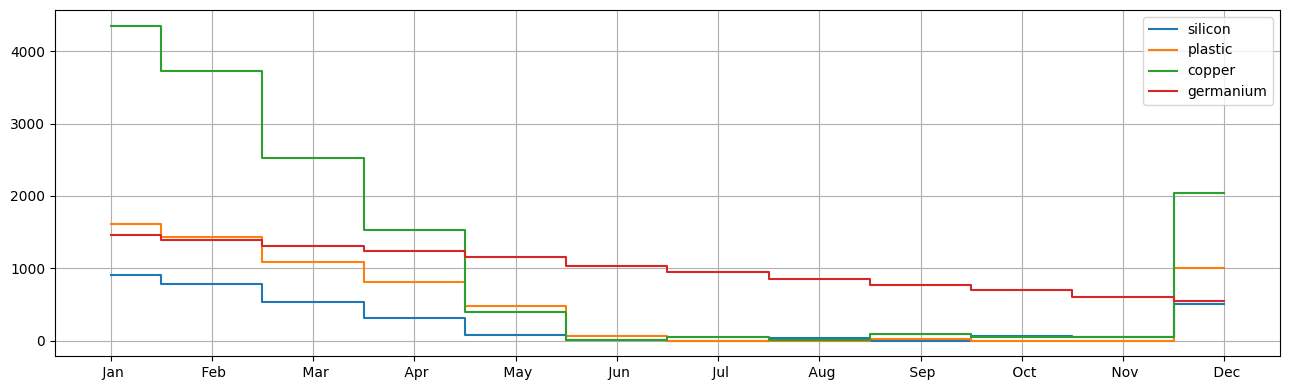

In [4]:
def Table1d(m, J, retriever):
    return pd.DataFrame([int(0 + retriever(m, j)) for j in J], index=J).T


def Table2d(m, I, J, retriever):
    return pd.DataFrame.from_records(
        [[int(0 + retriever(m, i, j)) for j in J] for i in I], index=I, columns=J
    )


def Table3d(m, I, J, names, K, retriever):
    index = pd.MultiIndex.from_product([I, J], names=names)
    return pd.DataFrame.from_records(
        [[int(0 + retriever(m, i, j, k)) for k in K] for i in I for j in J],
        index=index,
        columns=K,
    )


m1 = BIMproduction_v1(
    demand=demand,
    existing={"silicon": 1000, "germanium": 1500, "plastic": 1750, "copper": 4800},
    desired={"silicon": 500, "germanium": 500, "plastic": 1000, "copper": 2000},
    stock_limit=10000,
    supplying_copper=["B", "C"],
    supplying_batches=["A", "C"],
    price_copper_sheet={"B": 300, "C": 400},
    price_batch={"A": 500, "C": 600},
    discounted_price=700,
    batch_size=100,
    copper_sheet_mass=100,
    copper_bucket_size=10,
    unitary_products=["silicon", "germanium", "plastic"],
    unitary_holding_costs={"copper": 10, "silicon": 2, "germanium": 2, "plastic": 2},
)

print(
    f"Optimal cost is {pyo.value(m1.total_cost):.0f} cents, that is ${pyo.value(m1.total_cost) / 100:.2f}\n"
)

print("Monthly purchased material")
display(Table2d(m1, demand.index, demand.columns, lambda m, i, j: pyo.value(m.u[i, j])))

print("Acquisition plan for copper sheet and batch pairs from supplier C")
display(Table1d(m1, J=demand.columns, retriever=lambda m, j: pyo.value(m.p[j])))

print("Acquisition plan for copper sheets materials")
display(Table2d(m1, ["B", "C"], demand.columns, lambda m, i, j: pyo.value(m.y[j, i])))

print("Acquisition plan for unitary materials (batches)")
display(Table2d(m1, ["A", "C"], demand.columns, lambda m, i, j: pyo.value(m.b[j, i])))

print("Acquisition plan for unitary materials (quantities)")
display(
    Table3d(
        m1,
        I=["A", "C"],
        J=["silicon", "germanium", "plastic"],
        names=["supplier", "materials"],
        K=demand.columns,
        retriever=lambda m, i, j, k: 0 + pyo.value(m.x[j, k, i]),
    )
)

print(
    "The stock levels at the end of each month resulting from the optimal acquisition and production plan"
)
stock = Table2d(m1, demand.index, demand.columns, lambda m, i, j: pyo.value(m.s[i, j]))
display(stock)
stock.T.plot(drawstyle="steps-mid", grid=True, figsize=(13, 4))
plt.xticks(np.arange(len(stock.columns)), stock.columns)
plt.tight_layout()
plt.show()

## Alternative Pyomo implementation using blocks

In the next cell, we implement a second version of the same model, which is equivalent to the previous one, but uses Pyomo sets and block components to iterate over all the time indices.

In [5]:
def BIMproduction_v2(
    demand,
    existing,
    desired,
    stock_limit,
    supplying_copper,
    supplying_batches,
    price_copper_sheet,
    price_batch,
    discounted_price,
    batch_size,
    copper_sheet_mass,
    copper_bucket_size,
    unitary_products,
    unitary_holding_costs,
):
    m = pyo.ConcreteModel(
        "BIM product acquisition and inventory with sophisticated prices (using blocks)"
    )

    periods = demand.columns
    products = demand.index
    first = periods[0]
    prev = {j: i for i, j in zip(periods, periods[1:])}
    last = periods[-1]

    m.T = pyo.Set(initialize=periods)
    m.P = pyo.Set(initialize=products)

    m.PT = m.P * m.T  # to avoid internal set bloat

    @m.Block(m.T)
    def A(b):
        b.x = pyo.Var(supplying_batches, products, domain=pyo.NonNegativeReals)
        b.b = pyo.Var(supplying_batches, domain=pyo.NonNegativeIntegers)
        b.y = pyo.Var(supplying_copper, domain=pyo.NonNegativeIntegers)
        b.p = pyo.Var(domain=pyo.NonNegativeIntegers)

        @b.Constraint(supplying_batches)
        def in_batches(b, s):
            return pyo.quicksum(b.x[s, p] for p in products) <= batch_size * b.b[s]

        @b.Constraint()
        def pairs_in_batches(b):
            return b.p <= b.b["C"]

        @b.Constraint()
        def pairs_in_sheets(b):
            return b.p <= b.y["C"]

        @b.Expression(products)
        def u(b, p):
            if p == "copper":
                return copper_sheet_mass * pyo.quicksum(
                    b.y[s] for s in supplying_copper
                )
            return pyo.quicksum(b.x[s, p] for s in supplying_batches)

        @b.Expression()
        def cost(b):
            discount = price_batch["C"] + price_copper_sheet["C"] - discounted_price
            return (
                pyo.quicksum(price_copper_sheet[s] * b.y[s] for s in supplying_copper)
                + pyo.quicksum(price_batch[s] * b.b[s] for s in supplying_batches)
                - discount * b.p
            )

    @m.Block(m.T)
    def I(b):
        b.s = pyo.Var(products, domain=pyo.NonNegativeReals)
        b.r = pyo.Var(domain=pyo.NonNegativeIntegers)

        @b.Constraint()
        def copper_in_buckets(b):
            return b.s["copper"] <= copper_bucket_size * b.r

        @b.Constraint()
        def capacity(b):
            return b.s["copper"] <= stock_limit

        @b.Expression()
        def cost(b):
            return unitary_holding_costs["copper"] * b.r + pyo.quicksum(
                unitary_holding_costs[p] * b.s[p] for p in unitary_products
            )

    @m.Param(m.PT)
    def delta(m, t, p):
        return demand.loc[t, p]

    @m.Expression()
    def acquisition_cost(m):
        return pyo.quicksum(m.A[t].cost for t in m.T)

    @m.Expression()
    def inventory_cost(m):
        return pyo.quicksum(m.I[t].cost for t in m.T)

    @m.Objective(sense=pyo.minimize)
    def total_cost(m):
        return m.acquisition_cost + m.inventory_cost

    @m.Constraint(m.PT)
    def balance(m, p, t):
        if t == first:
            return existing[p] + m.A[t].u[p] == m.delta[p, t] + m.I[t].s[p]
        else:
            return m.A[t].u[p] + m.I[prev[t]].s[p] == m.delta[p, t] + m.I[t].s[p]

    @m.Constraint(m.P)
    def finish(m, p):
        return m.I[last].s[p] >= desired[p]

    SOLVER.solve(m)

    return m

We can then pass the parameters and data to this Pyomo model and solve it, as illustrated in the following code cell. We report the solution as a set of Pandas dataframes and visualize the monthly stock levels.

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Optimal cost is 110216 cents, that is $1102.16

The stock levels at the end of each month resulting from the optimal acquisition and production plan


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,912,787,527,310,72,15,0,35,24,0,54,500
plastic,1615,1427,1086,804,471,67,0,0,0,56,0,1000
copper,4354,3730,2528,1530,388,8,44,14,90,54,50,2042
germanium,1453,1391,1310,1245,1150,1032,946,857,775,693,609,543


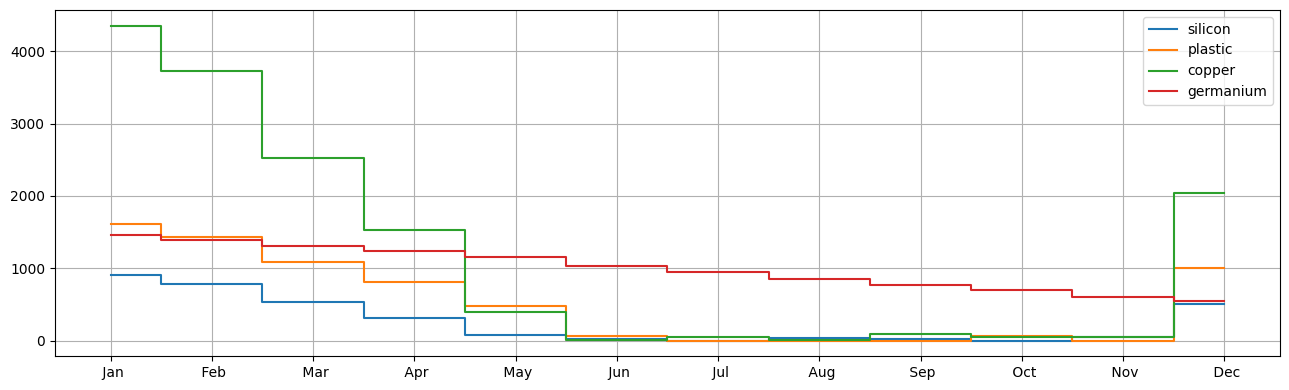

In [6]:
m2 = BIMproduction_v2(
    demand=demand,
    existing={"silicon": 1000, "germanium": 1500, "plastic": 1750, "copper": 4800},
    desired={"silicon": 500, "germanium": 500, "plastic": 1000, "copper": 2000},
    stock_limit=10000,
    supplying_copper=["B", "C"],
    supplying_batches=["A", "C"],
    price_copper_sheet={"B": 300, "C": 400},
    price_batch={"A": 500, "C": 600},
    discounted_price=700,
    batch_size=100,
    copper_sheet_mass=100,
    copper_bucket_size=10,
    unitary_products=["silicon", "germanium", "plastic"],
    unitary_holding_costs={"copper": 10, "silicon": 2, "germanium": 2, "plastic": 2},
)

print(
    f"Optimal cost is {pyo.value(m2.total_cost):.0f} cents, that is ${pyo.value(m2.total_cost) / 100:.2f}\n"
)

Table3d(
    m2,
    I=["A", "C"],
    J=["silicon", "germanium", "plastic"],
    names=["supplier", "materials"],
    K=m2.T,
    retriever=lambda m, i, j, k: 0 + pyo.value(m.A[k].x[i, j]),
)

print(
    "The stock levels at the end of each month resulting from the optimal acquisition and production plan"
)
stock = Table2d(m2, I=m2.P, J=m2.T, retriever=lambda m, i, j: pyo.value(m.I[j].s[i]))
display(stock)
stock.T.plot(drawstyle="steps-mid", grid=True, figsize=(13, 4))
plt.xticks(np.arange(len(stock.columns)), stock.columns)
plt.tight_layout()
plt.show()